# **<font color='#569098' size=20>Putting it All Together: Designing Proteins</font>**

##[Return to HomePage](https://github.com/Graylab/DL4Proteins-notebooks)

Parameters for running the pipeline are a minimal subset in the full [RFDiffusion notebook](https://colab.research.google.com/github/sokrypton/ColabDesign/blob/v1.1.1/rf/examples/diffusion.ipynb), by Sergey Ochinikov.

**OBJECTIVES:** By the end of this workshop you should be able to:

* <font color='#e59454'>Unconditionally Design a De Novo Protein</font>
* <font color='#e59454'>Perform Motif Scaffold Diffusion: Extend a Protein Loop</font>
* <font color='#e59454'>Design a De Novo Binder</font>


We will use a pipeline consisting of RFDiffusion (a diffusion model), Protein MPNN (a graph neural network), and Alphafold. Check out previous notebooks related to each below:

1.  <font color='#e59454'>[DDPM Notebook](https://colab.research.google.com/drive/1off5TdGgq00vxtBHOtPpPBBYwM_40UmH#scrollTo=q-41CCQNOt62)</font>
2.  <font color='#e59454'>[GNN Notebook](https://colab.research.google.com/drive/1VdnneRmaBTCfvZgnqZrfVR38xGKYTK2O?usp=sharing)</font>
3. <font color='#e59454'>[Alphafold](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g?usp=sharing)</font>


**_To save your work, please save a copy of this notebook into your personal google drive._**


**<font color='#99094' size = 3> Extracting Location of Antibody Framework Regions </font>**

In [1]:
import os
os.getcwd()

'c:\\Users\\karthik.raj\\Documents\\AB_ColabDesign\\ColabDesign'

In [2]:
!pip install biopython antpack==0.3.8.6 torch==2.5.0

In [3]:
import antpack
from Bio import SeqIO
from antpack import SingleChainAnnotator
import os
import pandas as pd
from helper import *

In [4]:
fasta_path = "../ManodInputs_scFv/internal_cd3_cd28.fasta"
anti_seqs = get_anti_seqs_from_fasta(fasta_path= fasta_path)
anti_seqs

{'anti_cd3': {'heavy': 'QVQLQQSGAELARPGASVKMSCKASGYTFTRYTMHWVKQRPGQGLEWIGYINPSRGYTNYNQKFKDKATLTTDKSSSTAYMQLSSLTSEDSAVYYCARYYDDHYCLDYWGQGTTLTVSS',
  'light': 'QIVLTQSPAIMSASPGEKVTMTCSASSSVSYMNWYQQKSGTSPKRWIYDTSKLASGVPAHFRGSGSGTSYSLTISGMEAEDAATYYCQQWSSNPFTFGSGTKLEIN'},
 'anti_cd28': {'heavy': 'QVQLKESGPGLVAPSQSLSITCTVSGFSLTSYGVHWVRQPPGKGLEWLGVIWAGGSTNYNSALMSRLSISKDNSKSQVFLKMNSLQTDDTAMYYCARDKRAPGKLYYGYPDYWGQGTTLTVSS',
  'light': 'DIVLTQSPASLAVSLGQRATISCRASESVEYYVTSLMQWYQQKPGQPPKLLIYAASNVESGVPARFSGSGSGTDFSLNIHPVEEDDIAMYFCQQTRKVPSTFGGGTKLEIK'}}

In [5]:
chain = 'heavy'
anti_name = 'anti_cd28'
scheme = 'martin'
heavy_seqs_list, heavy_region_dict, heavy_reg_labels = heatmap_setup(seq = [anti_seqs[anti_name][chain]], chain = chain[0].upper(), scheme = scheme)
print("Heavy Dict: ", heavy_region_dict)

Heavy Dict:  {'fmwk1': {'index_start': 0, 'index_end': 25}, 'cdr1': {'index_start': 25, 'index_end': 32}, 'fmwk2': {'index_start': 32, 'index_end': 51}, 'cdr2': {'index_start': 51, 'index_end': 56}, 'fmwk3': {'index_start': 56, 'index_end': 97}, 'cdr3': {'index_start': 97, 'index_end': 112}, 'fmwk4': {'index_start': 112, 'index_end': 123}}


In [6]:
chain = 'light'
light_seqs_list, light_region_dict, light_reg_labels = heatmap_setup(seq = [anti_seqs[anti_name][chain]], chain = chain[0].upper(), scheme = scheme)
print("Light Dict: ", light_region_dict)

Light Dict:  {'fmwk1': {'index_start': 0, 'index_end': 25}, 'cdr1': {'index_start': 25, 'index_end': 36}, 'fmwk2': {'index_start': 36, 'index_end': 53}, 'cdr2': {'index_start': 53, 'index_end': 56}, 'fmwk3': {'index_start': 56, 'index_end': 94}, 'cdr3': {'index_start': 94, 'index_end': 100}, 'fmwk4': {'index_start': 100, 'index_end': 111}}


In [7]:
linker = "GGGGSGGGGSGGGGS"
heavy_seq = anti_seqs[anti_name]['heavy']
light_seq = anti_seqs[anti_name]['light']
linker_length = len(linker)
linker_length

15

In [8]:
seq_len_dict = {'heavy' : len(heavy_seq), 'light' : len(light_seq), 'linker': len(linker)}
seq_len_dict

{'heavy': 123, 'light': 111, 'linker': 15}

In [9]:
def generate_scfv(heavy_chain: str, light_chain:str, linker: str, orientation: str) -> str:
  """ Generating scFVs based on provided input orientation """
  if orientation == 'VH-VL':
    scfv = f"{heavy_chain}{linker}{light_chain}"
  elif orientation == 'VL-VH':
    scfv = f"{light_chain}{linker}{heavy_chain}"
  return scfv
cd28_scfv = generate_scfv(heavy_seq, light_seq, linker, 'VL-VH')
cd28_scfv

'DIVLTQSPASLAVSLGQRATISCRASESVEYYVTSLMQWYQQKPGQPPKLLIYAASNVESGVPARFSGSGSGTDFSLNIHPVEEDDIAMYFCQQTRKVPSTFGGGTKLEIKGGGGSGGGGSGGGGSQVQLKESGPGLVAPSQSLSITCTVSGFSLTSYGVHWVRQPPGKGLEWLGVIWAGGSTNYNSALMSRLSISKDNSKSQVFLKMNSLQTDDTAMYYCARDKRAPGKLYYGYPDYWGQGTTLTVSS'

In [11]:
def generate_motif_scaffolding_contig(heavy_region_dict: dict, light_region_dict : dict, seq_len_dict: dict,  orientation: str) -> str:
  """ Generating motif scaffolding command for RFDiffusion, command varies based on orientation """

  # Define who is first and second chain based on orientation
  if orientation == 'VH-VL':
    first_chain = 'heavy'
    second_chain = 'light'
  elif orientation == 'VL-VH':
    first_chain = 'light'
    second_chain = 'heavy'

  # Define some parameters upon initialization
  chain_name = 'A'
  motif_scaffolding_contig_command = ''
  anti_dict = {}
  # Configure or design dictionary in the order of the orientation to ensure order is preserved in contig command
  if first_chain == 'heavy':
    anti_dict[first_chain] = heavy_region_dict
    anti_dict[second_chain] = light_region_dict
  elif first_chain == 'light':
    anti_dict[first_chain] = light_region_dict
    anti_dict[second_chain] = heavy_region_dict

  # Iterate through antibody dictionary in order of the orientation previously defined
  for chain, reg_dict in anti_dict.items():

    # Have to account for linker and heavy chain length when defining positions for light chain
    if chain == first_chain:
      adj = 0
    elif chain == second_chain:
      adj = seq_len_dict['linker'] + seq_len_dict[first_chain]

    # For each cdr/fr region in a given chain:
    for reg, loc_dict in reg_dict.items():

      # For FR regions
      if "fmwk" in reg:
        fr_length = loc_dict['index_end'] - loc_dict['index_start']
        generate_fr_command = str(fr_length) + "/"
        motif_scaffolding_contig_command += generate_fr_command

      # For CDR regions
      if "cdr" in reg:
        # Account for Zero-Indexing but Command for Scaffolding is 1-indexed, keep in mind returned indices are for a range where end index is not included in slice,
        # In our case, we do want to include end index and so if we add another +1 on top of it get an extra residue
        cdr_start, cdr_end = loc_dict['index_start'] + 1 + adj, loc_dict['index_end'] + adj
        generate_cdr_command = f"{chain_name}{cdr_start}-{cdr_end}/"
        motif_scaffolding_contig_command += generate_cdr_command

    # After running through, command generation for heavy chain account for linker
    if chain == first_chain:
      # If using the length directly for start index, will be referring to final residue of heavy variable region
      motif_scaffolding_contig_command += f"A{seq_len_dict[first_chain] + 1}-{seq_len_dict[first_chain]+ linker_length}/"

  # Have to add chain break as want to do motif scaffolding in presence of specific chain in target responsible for binding
  # for CD28: its B1-118
  motif_scaffolding_contig_command += "0 B1-118"
  motif_scaffolding_contig_command
  return motif_scaffolding_contig_command

In [12]:
motif_scaffolding_contig_command = generate_motif_scaffolding_contig(heavy_region_dict, light_region_dict, seq_len_dict, 'VL-VH')
motif_scaffolding_contig_command

'25/A26-36/17/A54-56/38/A95-100/11/A112-126/25/A152-158/19/A178-182/41/A224-238/11/0 B1-118'

**<font color='#569098' size = 5> Table of Contents </font>**

**[Section 1: Introduction](https://colab.research.google.com/drive/1SaAbRZTA7Uf-arLrOHbAkzJo52N1q2tW#scrollTo=wVUVM8qy7A2H&line=1&uniqifier=1)**

**[Section 2: Unconditional Diffusion](https://colab.research.google.com/drive/1RCar-Qt-TjfnRyMgzMSO-OKu7sFVR8hR#scrollTo=rJyGOZkG7OqT&line=5&uniqifier=1)**

**[Section 3: Motif Scaffolding](https://colab.research.google.com/drive/1RCar-Qt-TjfnRyMgzMSO-OKu7sFVR8hR#scrollTo=49kUXQgLSAa4&line=1&uniqifier=1)**

**[Section 4: Binder Design](https://colab.research.google.com/drive/1RCar-Qt-TjfnRyMgzMSO-OKu7sFVR8hR#scrollTo=QboJfO8lQXuZ&line=7&uniqifier=1)**

In [ ]:
#@title Run to set up notebook (~3min)
%%time
import os, time, signal
import sys, random, string, re

if 'RFdiffusion' not in sys.path:
  os.environ["DGLBACKEND"] = "pytorch"
  sys.path.append('RFdiffusion')

from google.colab import files
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

def get_pdb(pdb_code=None):
  """ Function to either download a specific PDB file from the PDB or enable the user to directly upload their own PDB """
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    if not os.path.isfile(f"{pdb_code}.pdb1"):
      os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz")
      os.system(f"gunzip {pdb_code}.pdb1.gz")
    return f"{pdb_code}.pdb1"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

def run_ananas(pdb_str, path, sym=None):
  """ Function to run the AnAnaS Symmetry Detection Tool on an input PDB and apply subsequent transformation if necessary """
  pdb_filename = f"outputs/{path}/ananas_input.pdb"
  out_filename = f"outputs/{path}/ananas.json"
  with open(pdb_filename,"w") as handle:
    handle.write(pdb_str)

  cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
  if sym is None: os.system(cmd)
  else: os.system(f"{cmd} {sym}")

  # parse results
  try:
    out = json.loads(open(out_filename,"r").read())
    results,AU = out[0], out[-1]["AU"]
    group = AU["group"]
    chains = AU["chain names"]
    rmsd = results["Average_RMSD"]
    print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")

    C = np.array(results['transforms'][0]['CENTER'])
    A = [np.array(t["AXIS"]) for t in results['transforms']]

    # apply symmetry and filter to the asymmetric unit
    new_lines = []
    for line in pdb_str.split("\n"):
      if line.startswith("ATOM"):
        chain = line[21:22]
        if chain in chains:
          x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
          if group[0] == "c":
            x = sym_it(x,C,A[0])
          if group[0] == "d":
            x = sym_it(x,C,A[1],A[0])
          coord_str = "".join(["{:8.3f}".format(a) for a in x])
          new_lines.append(line[:30]+coord_str+line[54:])
      else:
        new_lines.append(line)
    return results, "\n".join(new_lines)

  except:
    return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):
  """ Execution Wrapper to retrieve in-progress diffused designs and display them to the user. Also creates progress bar highlighting degree of progress made during diffusion process """

  def run_command_and_get_pid(command):
    pid_file = '/dev/shm/pid'
    os.system(f'nohup {command} & echo $! > {pid_file}')
    with open(pid_file, 'r') as f:
      pid = int(f.read().strip())
    os.remove(pid_file)
    return pid
  def is_process_running(pid):
    try:
      os.kill(pid, 0)
    except OSError:
      return False
    else:
      return True

  run_output = widgets.Output()
  progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
  display(widgets.VBox([progress, run_output]))

  # clear previous run
  for n in range(steps):
    if os.path.isfile(f"/dev/shm/{n}.pdb"):
      os.remove(f"/dev/shm/{n}.pdb")

  pid = run_command_and_get_pid(command)
  try:
    fail = False
    for _ in range(num_designs):

      # for each step check if output generated
      for n in range(steps):
        wait = True
        while wait and not fail:
          time.sleep(0.1)
          if os.path.isfile(f"/dev/shm/{n}.pdb"):
            pdb_str = open(f"/dev/shm/{n}.pdb").read()
            if pdb_str[-3:] == "TER":
              wait = False
            elif not is_process_running(pid):
              fail = True
          elif not is_process_running(pid):
            fail = True

        if fail:
          progress.bar_style = 'danger'
          progress.description = "failed"
          break

        else:
          progress.value = (n+1) / steps
          if visual != "none":
            with run_output:
              run_output.clear_output(wait=True)
              if visual == "image":
                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                fig = plt.figure()
                fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1)
                plt.show()
              if visual == "interactive":
                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                view.addModel(pdb_str,'pdb')
                view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                view.zoomTo()
                view.show()
        if os.path.exists(f"/dev/shm/{n}.pdb"):
          os.remove(f"/dev/shm/{n}.pdb")
      if fail:
        progress.bar_style = 'danger'
        progress.description = "failed"
        break

    while is_process_running(pid):
      time.sleep(0.1)

  except KeyboardInterrupt:
    os.kill(pid, signal.SIGTERM)
    progress.bar_style = 'danger'
    progress.description = "stopped"

def run_diffusion(contigs, path, pdb=None, iterations=50,
                  symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False, partial_T="auto",
                  num_designs=1, use_beta_model=False, use_ab_model = False, visual="none"):


  # Create output saving directory of the designs created by diffusion process
  full_path = f"outputs/{path}" # path by default for motif-scaffolding is motif indicating saving results in outputs/motif folder
  os.makedirs(full_path, exist_ok=True)
  # Start of a list of command-line arguments that are expanded based on user-provided options and finally converted to a string to run in th notebook
  opts = [f"inference.output_prefix={full_path}",
          f"inference.num_designs={num_designs}"]

  if chains == "": chains = None

  # determine symmetry type
  if symmetry in ["auto","cyclic","dihedral"]:
    if symmetry == "auto":
      sym, copies = None, 1
    else:
      sym, copies = {"cyclic":(f"c{order}",order),
                     "dihedral":(f"d{order}",order*2)}[symmetry]
  else:
    symmetry = None
    sym, copies = None, 1

  # determine mode
  contigs = contigs.replace(","," ").replace(":"," ").split()
  is_fixed, is_free = False, False
  fixed_chains = []
  for contig in contigs:
    for x in contig.split("/"): # Split first by regions indicated in command typically "A1-10/20" so now A1-10 and 20
      a = x.split("-")[0] # for A1-10 the split will return A1 allowing you to identify specific chain is being provided to be preserved if first char of A1 is alphabet, for 20 will just get 20 back
      if a[0].isalpha(): # Fixed backbone because specified parts of a chain indicated by captial letter (A) to preserve
        is_fixed = True
        if a[0] not in fixed_chains:
          fixed_chains.append(a[0])
      if a.isnumeric(): # 20 will trigger this condition as there is a part of the design that is free for design/diffusion
        is_free = True
  if len(contigs) == 0 or not is_free: # Only realistically triggers if input contigs is empty, goal is to diffuse entire input PDB to sample different conformations
    mode = "partial"
  elif is_fixed: # in current case, have both is_fixed as True and is_free as True
    mode = "fixed"
  else: # De-Novo Design with input being 20/20/30. Create 3 chains of lengths: 20. 20. 30
    mode = "free"

  # fix input contigs, just to account for potential symmetry in the input PDB that must be preserved
  if mode in ["partial","fixed"]:
    pdb_str = pdb_to_string(get_pdb(pdb), chains=chains)
    if symmetry == "auto":
      a, pdb_str = run_ananas(pdb_str, path)
      if a is None:
        print(f'ERROR: no symmetry detected')
        symmetry = None
        sym, copies = None, 1
      else:
        if a["group"][0] == "c":
          symmetry = "cyclic"
          sym, copies = a["group"], int(a["group"][1:])
        elif a["group"][0] == "d":
          symmetry = "dihedral"
          sym, copies = a["group"], 2 * int(a["group"][1:])
        else:
          print(f'ERROR: the detected symmetry ({a["group"]}) not currently supported')
          symmetry = None
          sym, copies = None, 1

    elif mode == "fixed":
      pdb_str = pdb_to_string(pdb_str, chains=fixed_chains) # Retain a text version of the PDB file containing row by row atoms defining residues in the respective kept/preserved/fixed chains

    # Storing only the chains that want to either be fixed or in the presence of scaffolding in the text copy of the PDB file and later written as new PDB file denoted by input.pdb
    pdb_filename = f"{full_path}/input.pdb"
    with open(pdb_filename, "w") as handle:
      handle.write(pdb_str)

    parsed_pdb = parse_pdb(pdb_filename)
    opts.append(f"inference.input_pdb={pdb_filename}") # Adding input pdb file path as a command line argument
    if mode in ["partial"]:
      if partial_T == "auto":
        iterations = int(80 * (iterations / 200))
      else:
        iterations = int(partial_T)
      opts.append(f"diffuser.partial_T={iterations}")
      contigs = fix_partial_contigs(contigs, parsed_pdb)
    else:
      opts.append(f"diffuser.T={iterations}")
      contigs = fix_contigs(contigs, parsed_pdb)
  else: # For fixed backbone diffusion, only diffusing for set number of iterations provided by the user
    opts.append(f"diffuser.T={iterations}")
    parsed_pdb = None
    contigs = fix_contigs(contigs, parsed_pdb)

  # Valuable for both motif scaffolding and de novo binder design. Highlighting residues want favorable interactions with
  if hotspot is not None and hotspot != "": # Series of potential epitope residues B20, B40. That you do want favorable interactions with
    hotspot = ",".join(hotspot.replace(","," ").split())
    opts.append(f"ppi.hotspot_res='[{hotspot}]'")

  # setup symmetry
  if sym is not None:
    sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
    if add_potential:
      sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'",
                   "potentials.olig_intra_all=True","potentials.olig_inter_all=True",
                   "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
    opts = sym_opts + opts
    contigs = sum([contigs] * copies,[])

  opts.append(f"'contigmap.contigs=[{' '.join(contigs)}]'")
  opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]
  if use_beta_model:
    opts += ["inference.ckpt_override_path=./RFdiffusion/models/Complex_beta_ckpt.pt"]
  # Added RFAntibody as a model inference overide path to use during inference
  if use_ab_model:
    opts += ["inference.ckpt_override_path=./RFdiffusion/models/RFdiffusion_Ab.pt"]

  print("mode:", mode)
  print("output:", full_path)
  print("contigs:", contigs)

  opts_str = " ".join(opts)
  cmd = f"./RFdiffusion/run_inference.py {opts_str}"
  print(cmd)

  # RUN
  run(cmd, iterations, num_designs, visual=visual)

  # fix pdbs
  for n in range(num_designs):
    pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb",
            f"outputs/traj/{path}_{n}_Xt-1_traj.pdb",
            f"{full_path}_{n}.pdb"]
    for pdb in pdbs:
      with open(pdb,"r") as handle: pdb_str = handle.read()
      with open(pdb,"w") as handle: handle.write(fix_pdb(pdb_str, contigs))

  return contigs, copies

# Visualizing results
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  pdb_traj = f"outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  Ls = get_Ls(contigs)
  xyz, bfact = get_ca(pdb_traj, get_bfact=True)
  xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
  bfact = bfact.reshape((-1,sum(Ls)))[::-1]
  display(HTML(make_animation(xyz, plddt=bfact*100, dpi=300, ref=-1)))

import py3Dmol
def plot_pdb_final(num = "best"):
  if num == "best": # Identify best MPNN design from all seq designs created for each RFDiffusion designed model
    with open(f"outputs/{path}/best.pdb","r") as f:
      # REMARK 001 design {m} N {n} RMSD {rmsd}
      info = f.readline().strip('\n').split()
    num = info[3]
  hbondCutoff = 4.0
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  pdb_str = open(f"outputs/{path}_{num}.pdb",'r').read() # Retrieve original RFDiffusion PDB labeled by _(RFDiffusion Design #) used as input for best MPNN design
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  pdb_str = open(f"outputs/{path}/best_design{num}.pdb",'r').read() # Retrieve best MPNN pdb for that design
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

  view.setStyle({"model":0},{'cartoon':{}}) #: {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.setStyle({"model":1},{'cartoon':{'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.zoomTo()
  view.show()

installing RFdiffusion...
installing ColabDesign...
downloading RFdiffusion params...


/content/RFdiffusion/diffusion.py:276: SyntaxWarning: invalid escape sequence '\s'
  Extract \sigma(t) corresponding to chosen sigma schedule.
/content/RFdiffusion/diffusion.py:303: SyntaxWarning: invalid escape sequence '\i'
  sigma(t)^2 := \int_0^t g(s)^2 ds,
/usr/local/lib/python3.12/dist-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

CPU times: user 5.85 s, sys: 864 ms, total: 6.71 s
Wall time: 2min 3s


# **<font color='#569098'> Section 1: Introduction</font>**

Our pipeline puts together various tools to design a protein:

1. <font color='#e59454'><u>RFDiffusion</u></font> -- Just as image generation tools like DALL-E denoise random noise to generate images, RFDiffusion denoises 3D Gaussian noise to make protein backbones. Note: These backbones are simply shapes, and do not have amino acids.

2. <font color='#e59454'><u>ProteinMPNN</u></font> -- Because backbones don't have amino acids, we have to add them with 'inverse folding models.' ProteinMPNN does this: it takes a glycine (empty) backbone from RFDiffusion and adds amino acids likely to fold into the same shape. The tool uses a message passing graph neural network to sample amino acids for the backbone.

3. <font color='#e59454'><u>Alphafold</u></font> -- ProteinMPNN just gives us a sequence of amino acids. To make sure that this sequence folds as we expect, Alphafold is used as a third party verfication method, checking that the folded sequence matches our original backbone.

Using this pipeline, this notebook examines how to do three tasks.









# **<font color='#569098'>Section 2: Unconditional Diffusion</font>**

Unconditional diffusion tells RFDiffusion to just sample a random backbone based on all the proteins it has seen before. We might use this to run statistics on the model, run experiments on protein stabilities, or make a set of random backbones that will be used for something down the line.

To diffuse an unconditional backbone, we put a the number of residues we want in the backbone as the `contigs` parameter. In general, we `contigs` to define continious chains. We use a `:` to define multiple contigs and a `/` to define mutliple segments within a contig. Try to edit the parameters below to diffuse a protein with 100 residues!

Some examples of more advanced usages are performing symmetric diffusion or making multimers (open the code and see if you can find the flags for those options).

In [ ]:
%%time
#@title Run Unconditional Design Pipeline
#@markdown Run **RFdiffusion** to generate a backbone. Replace contigs with desired residue numbers. More iterations will lead to more denoising steps - if the backbone is not converging to a high confidence shape, you can increase this value to have a slower, but more stable diffusion process.

# PARAMETERS
name = "unconditional"
contigs = "100" #@param {type:"string"}
pdb = ""
iterations = 25 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = ""
num_designs = 1
visual = "interactive"
symmetry = "none"
order = 1
chains = ""
add_potential = True
partial_T = "auto"
use_beta_model = True # original False
# Check RFDiffusion Notebook for details on symmetric diffusion

# determine where to save
path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "use_beta_model":use_beta_model,
         "visual":visual,
         "partial_T":partial_T}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')
print("RUNNING RFDIFFUSION")
contigs, copies = run_diffusion(**flags)


RUNNING RFDIFFUSION
mode: free
output: outputs/unconditional_z41p5
contigs: ['100-100']
./RFdiffusion/run_inference.py inference.output_prefix=outputs/unconditional_z41p5 inference.num_designs=1 diffuser.T=25 'contigmap.contigs=[100-100]' inference.dump_pdb=True inference.dump_pdb_path='/dev/shm' inference.ckpt_override_path=./RFdiffusion/models/Complex_beta_ckpt.pt


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/traj/unconditional_z41p5_0_pX0_traj.pdb'

In [ ]:
# Run Protein MPNN and Alphafold

#@markdown Run **ProteinMPNN** to generate a sequence. ProteinMPNN can generate multiple sequences for the same backbone. You can also increase sampling temperature to get more diverse sequences.
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C"
use_solubleMPNN = False

#@markdown Run **AlphaFold** to validate. The original backbone will be shown in gray, and the Alphafold structure will be superimposed in color on top of it.
initial_guess = False
num_recycles = 2 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
use_multimer = False

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]
if initial_guess: opts.append("--initial_guess")
if use_multimer: opts.append("--use_multimer")
if use_solubleMPNN: opts.append("--use_soluble")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

# Show Alphafold output
print("DISPLAYING ALPHAFOLD RESULTS")
if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb_final(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb_final(dropdown.value)
else:
  plot_pdb_final()

{'pdb':'outputs/unconditional_0.pdb','loc':'outputs/unconditional','contigs':'100-100','copies':1,'num_seqs':8,'initial_guess':False,'use_multimer':False,'use_soluble':False,'num_recycles':2,'rm_aa':'C','num_designs':1,'mpnn_sampling_temp':0.1}
protocol=fixbb
running proteinMPNN...
running AlphaFold...
design:0 n:0 mpnn:1.047 plddt:0.800 ptm:0.643 pae:7.311 rmsd:1.561 MIEERELKLDIEDLVEVVKKNKKSKIEVSVEDGKVIITVEGESEKFLKLLEEKKGKGKNKFKITIEKLPDGSLVLTIEPEESVSPEELAEKIKKAIEEKK
design:0 n:1 mpnn:1.090 plddt:0.817 ptm:0.731 pae:5.884 rmsd:0.991 MRVERELRLDVADLVEVVLANAESKIEVSVEDGRVVLTVSGQADAFLAALEARAGRGRHRWRVTVERLPSGDVVLTLTPEPEVSAEDIAAAIEAAIAAKA
design:0 n:2 mpnn:1.047 plddt:0.857 ptm:0.699 pae:5.619 rmsd:1.693 MITKETLKIDIEDLVEVIKENKNSKIEVEVKDGEIIVTISGEEEEFLKKLKAKAGKGENTFEVTIEKKEDGTVVLTIKPDPEISAEDIAEKLKAAIKEKE
design:0 n:3 mpnn:1.040 plddt:0.838 ptm:0.688 pae:6.169 rmsd:1.804 MIIEEELYIDIEDLVEVIKENKNSKIEVEVENGKIIIKVSGESEEFLKLLKEKKGKGKNKVKVTIEKKENGDIIITITWEESVSSEEVAEKIEKAIEEKK
design:0 n:4 mpnn:1.083 

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# **<font color='#569098'>Section 3: Motif Scaffolding</font>**

In motif scaffolding, we define a scaffold - a known protein or protein part (e.g., binding site) that we want to build off of. We can use RFDiffusion to make an extra part that either stabilizes the scaffold or maybe bridges together two parts of the scaffold.

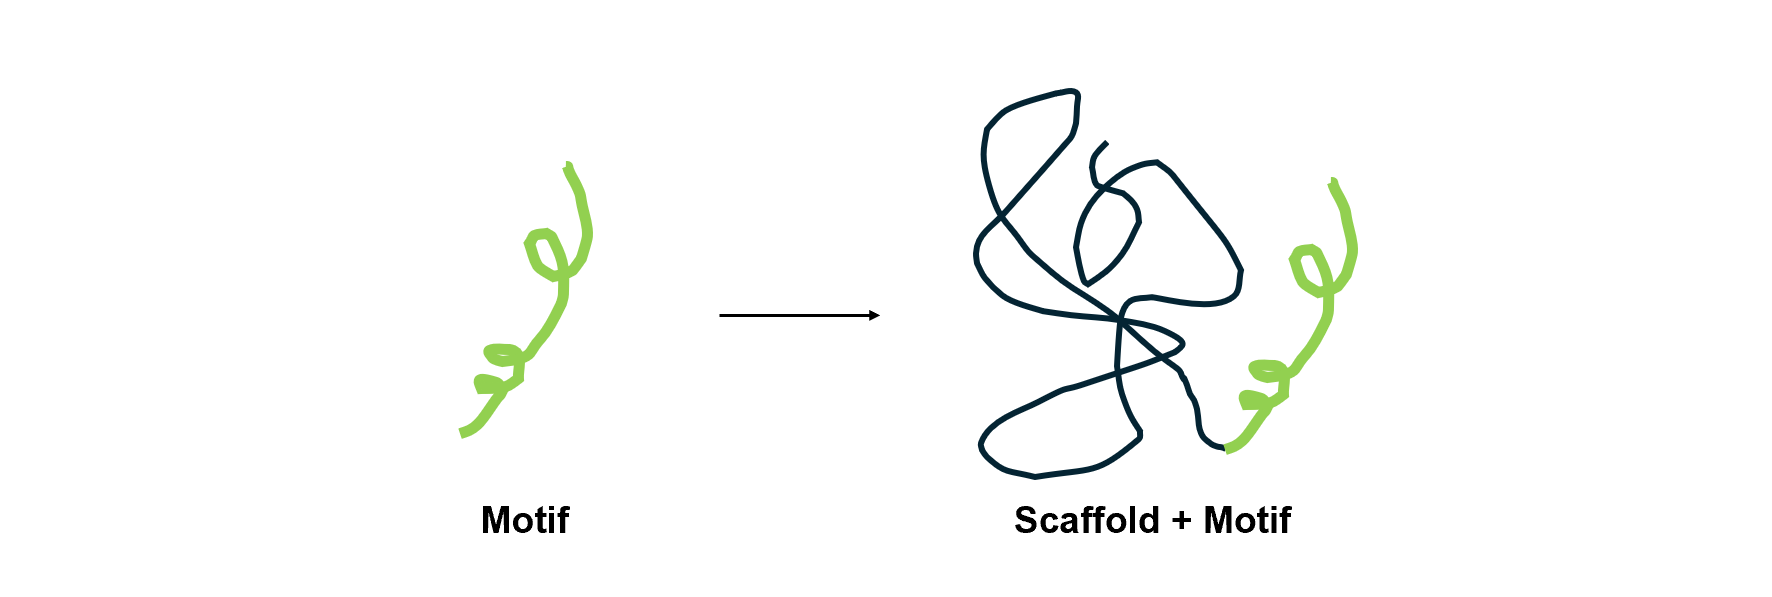

For example, `contigs='A163-181/40'` will take residues 163-181 of Chain A and extend 40 residues on the carboxyl end. Here, A163-181 could be some sort of active or binding site we are trying to stabilize from a larger protein. Knowing this, let's try to do the second task - using diffusion between two scaffold parts.


<font color='#e59454'>**Task Description**</font>

ABLE (PDB ID: [`6w70`](https://www.rcsb.org/structure/6w70)) is a *de novo* protein designed to bind the drug Apixaban. The protein is a helical bundle with four alpha-helicies, which help form a cavity to sequester the target molecule.

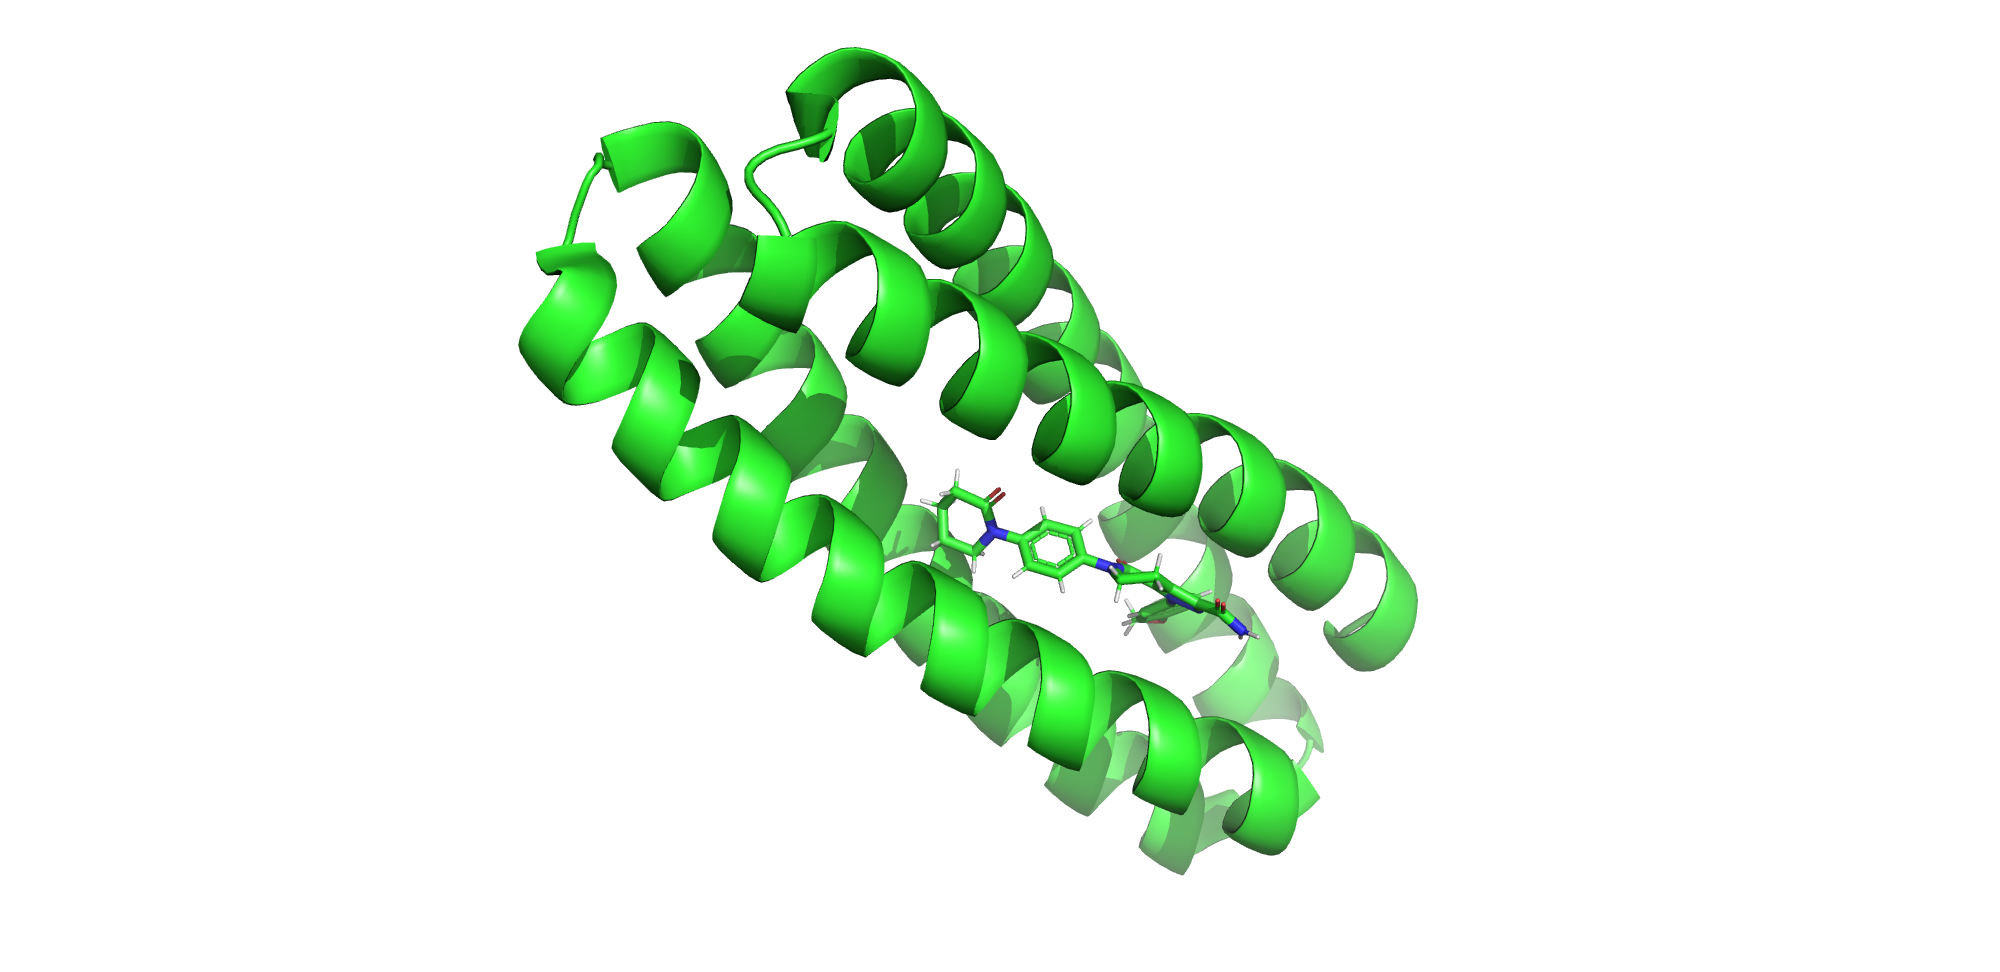


You hear through one of your collegues that there exists a mythical variant called ABLE-D (dimeric ABLE), which has never been imaged before. You are curious about ABLE-D and try to design something similar using our motif scaffolding pipeline.

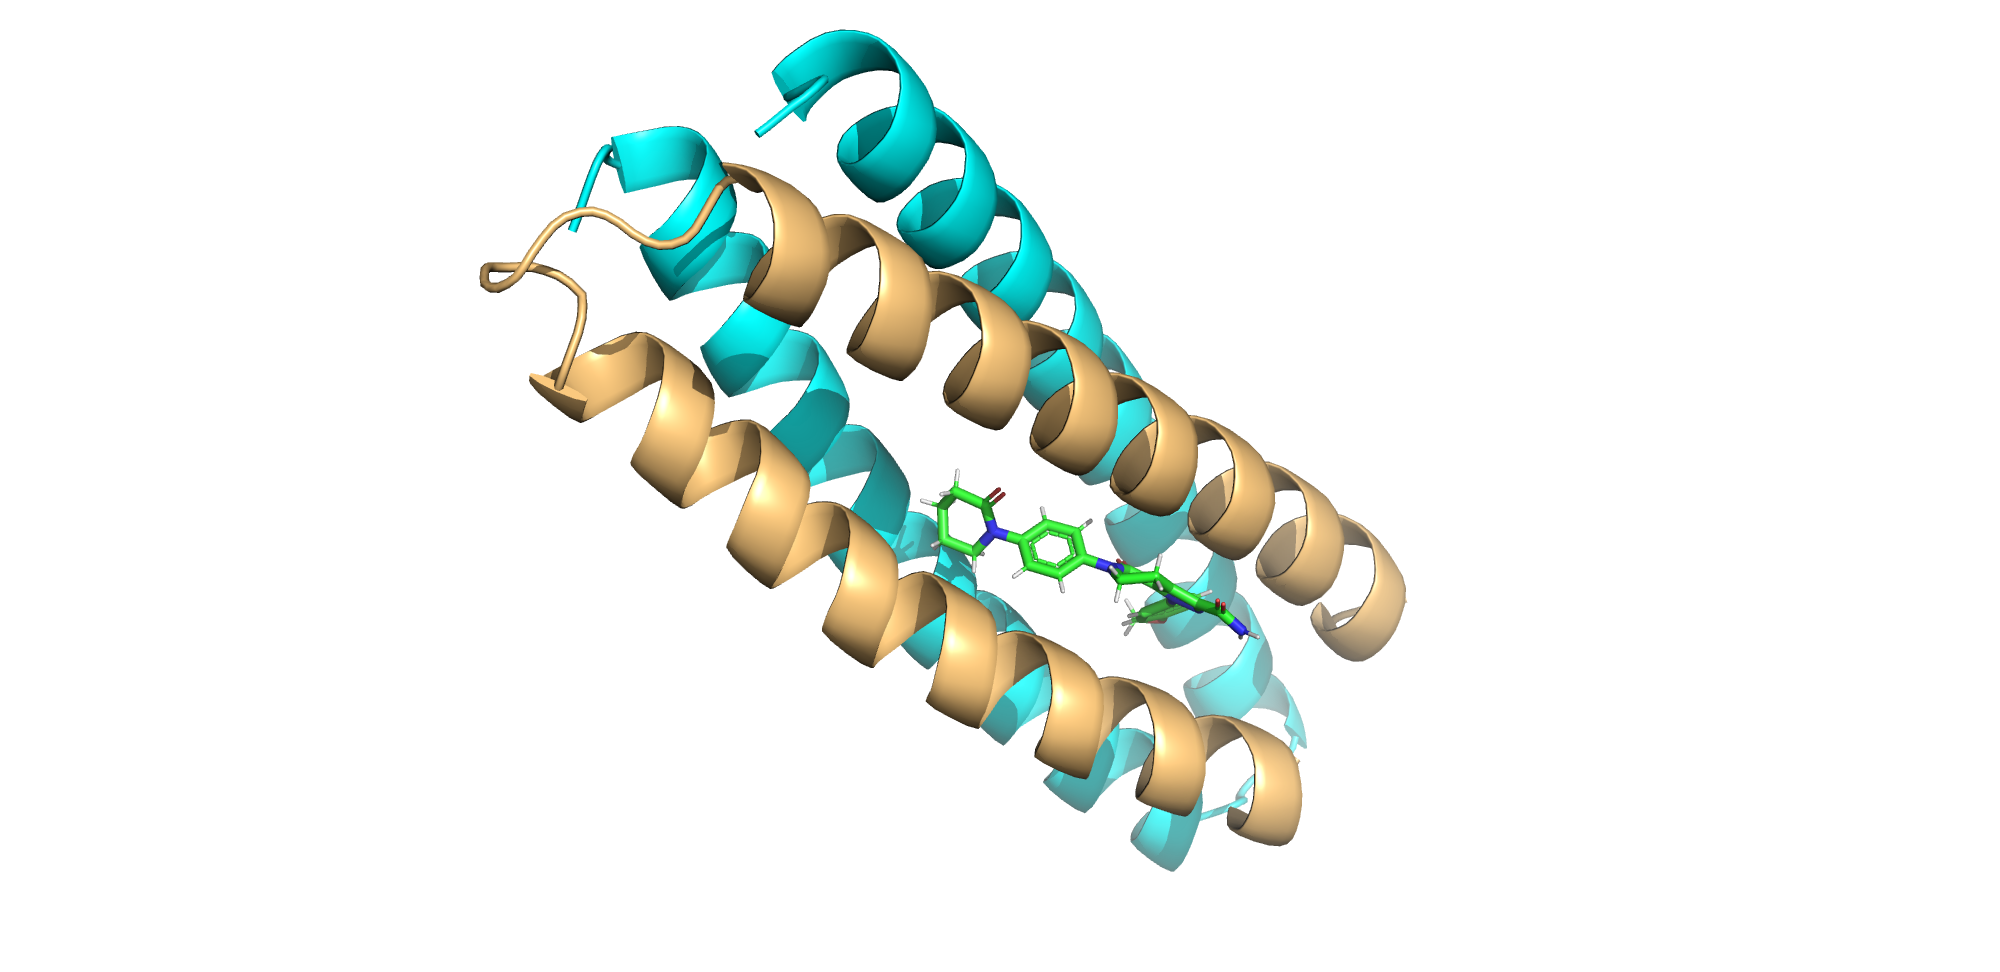

**Keep in mind:**

For `contigs`:
* `:` indicates a chain break
* `/` to defines multiple segments

*If we were running each tool separately, we would also add flags for extra flags for ProteinMPNN to only determine new amino acids for the residues that we diffuse. This is automatically accounted for in our pipeline, so the only flags you will have to play with are for RFDiffusion!*

Note: You may have to download the PDB file and play around to find the correct residues.

In [ ]:
#@markdown Run to show 6w70
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
path = get_pdb("6w70")
pdb_str = open(path,'r').read()
view.addModel(pdb_str,'pdb',{'hbondCutoff':4.0})
view.setStyle({"model":0},{'cartoon':{'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
%%time
#@title Run Motif Scaffolding Pipeline
#@markdown Run **RFdiffusion** to generate a linker between two helicies of ABLE and leave the other two connected. Remember to indicate that both proteins are present in the contigs line.
name = "motif"
contigs = "A1-29/5-5/A98-126 : A30-97" #@param {type:"string"}
contigs = motif_scaffolding_contig_command
pdb = "6W70" #@param {type:"string"}
pdb = "/content/drive/MyDrive/Docking via Haddock/cd28_scfv_vl_vh_top_docked.pdb"
iterations = 25 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = ""
num_designs = 3
visual = "interactive"
symmetry = "none"
order = 1
chains = ""
add_potential = True
partial_T = "auto"
use_beta_model = False
use_ab_model = False

# determine where to save
path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))


flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "use_beta_model":use_beta_model,
         "use_ab_model":use_ab_model,
         "visual":visual,
         "partial_T":partial_T}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')
print("RUNNING RFDIFFUSION")
contigs, copies = run_diffusion(**flags)


RUNNING RFDIFFUSION
mode: fixed
output: outputs/motif_qcwgq
contigs: ['25-25/A26-36/17-17/A54-56/38-38/A95-100/11-11/A112-126/25-25/A152-158/19-19/A178-182/41-41/A224-238/11-11', 'B1-118']
./RFdiffusion/run_inference.py inference.output_prefix=outputs/motif_qcwgq inference.num_designs=3 inference.input_pdb=outputs/motif_qcwgq/input.pdb diffuser.T=25 'contigmap.contigs=[25-25/A26-36/17-17/A54-56/38-38/A95-100/11-11/A112-126/25-25/A152-158/19-19/A178-182/41-41/A224-238/11-11 B1-118]' inference.dump_pdb=True inference.dump_pdb_path='/dev/shm'


CPU times: user 1.6 s, sys: 247 ms, total: 1.85 s
Wall time: 8min 47s


In [ ]:
# Run Protein MPNN and Alphafold

#@markdown Run **ProteinMPNN** to generate a sequence.
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C"
use_solubleMPNN = False # Originally False

#@markdown Run **AlphaFold** to validate.
num_recycles = 6 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
use_multimer = False # Originally False

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]

if use_multimer: opts.append("--use_multimer")
if use_solubleMPNN: opts.append("--use_soluble")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

# Show Alphafold output
print("DISPLAYING ALPHAFOLD RESULTS")
if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb_final(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb_final(dropdown.value)
else:
  plot_pdb_final()


{'pdb':'outputs/motif_qcwgq_0.pdb','loc':'outputs/motif_qcwgq','contigs':'25-25/A26-36/17-17/A54-56/38-38/A95-100/11-11/A112-126/25-25/A152-158/19-19/A178-182/41-41/A224-238/11-11:B1-118','copies':1,'num_seqs':8,'initial_guess':False,'use_multimer':False,'use_soluble':False,'num_recycles':6,'rm_aa':'C','num_designs':3,'mpnn_sampling_temp':0.1}
protocol=partial
running proteinMPNN...
running AlphaFold...
design:0 n:0 mpnn:1.104 plddt:0.490 ptm:0.382 pae:18.612 rmsd:22.913 MTVDQLIAWLKEQIDKAIEEAVAKLSESVEYYVTSLLYAVVETDSGELIQVSSAASSKTYTRTVQVDDNTAIRSTGRFSVLSAPTQTLKTTLYSTRKVPSTSYYIETTVETGGGGSGGGGSGGGGSFSLSDIYVRFTYEGKEYAVQIKVFNGFSLTSYGVRMELFDEESGLEIEIRVWAGGSRRMYVLRWNEDGSRELVEESEIEEIDPSGLKWEDKEALVSTDKRAPGKLYYGYPDYVLKTTVKIAEL/NKILVKQSPMLVAYDNAVNLSCKYSYNLFSREFRASLHKGLDSAVEVCVVYGNYSQQLQVYSKTGFNCDGKLGNESVTFYLQNLYVNQTDIYFCKIEVMYPPPYLDNEKSNGTIIHVK
design:0 n:1 mpnn:1.082 plddt:0.604 ptm:0.495 pae:14.636 rmsd:8.814 ATVAQGIAALRAQIAAAIETALAKLSESVEYYVTSLLYMVVEDDSGELVQVTSAASTTTYTSTRLTDPTTAVRSSGRFSITWAATQT

In [ ]:
#@markdown Stuck? Check examples below for hints. Or run to check your answer.
print("contigs=A1-29/5/A98-126:A30-97")
print("pdb=6W70")

contigs=A1-29/5/A98-126:A30-97
pdb=6W70


# **<font color='#569098'>Section 4: Binder Diffusion</font>**

Our last objective is to use the pipeline to generate a completely new binder. New binders could be used to probe different biological systems by interacting with or tagging other proteins, or potentially be developed into novel therapeutics.

<font color='#e59454'>**Task Description**</font>

Let's pretend that you made ABLE-D in lab, and you found that it doesn't bind Apixaban anymore. Although you are sad that ABLE-D didn't live up to your expectations - you come up with a new idea: what if you can rescue the binding affinity by using another protein to stabilize ABLE-D's binding state?


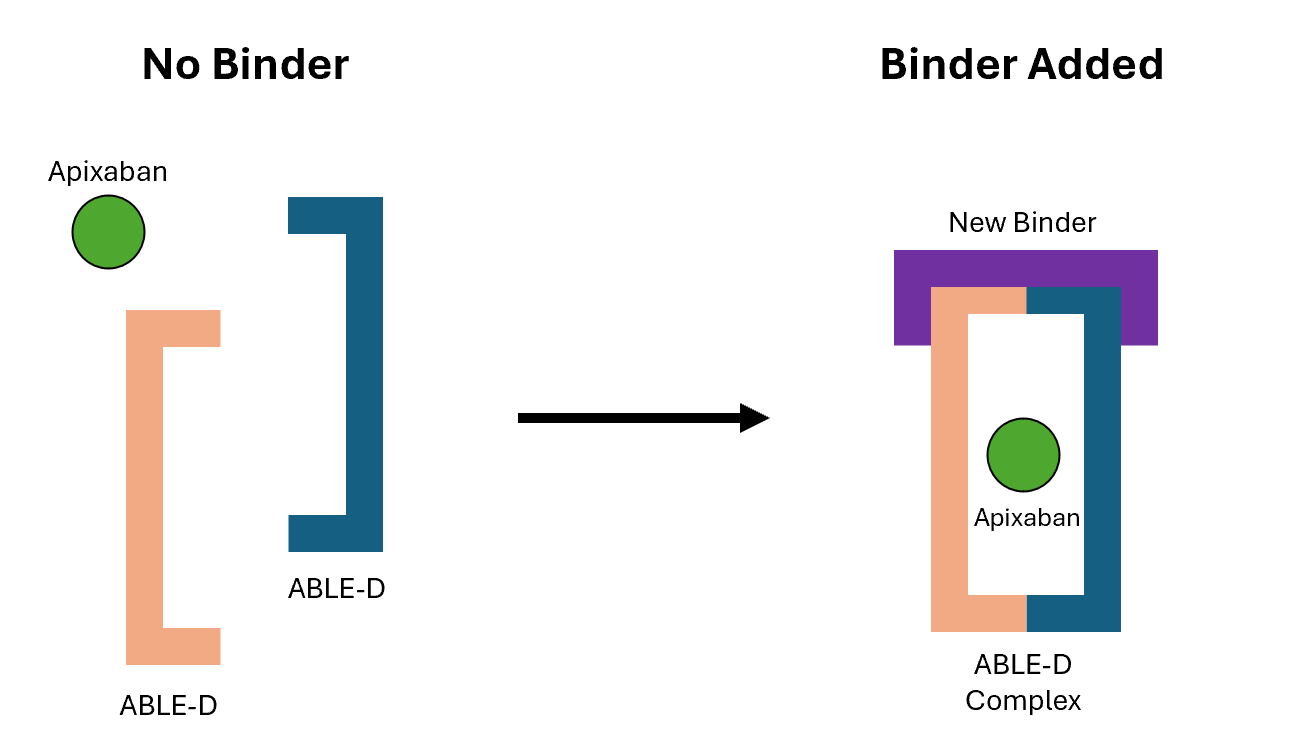

Think about how you might use the pipeline to diffuse such a binder. You will need to edit `contigs` to denote an extra protein of a certain size, and also edit the new `hotspot` flag that has been unhidden to specify possible areas of contact between ABLE-D and the new binder.

As an example, here are the inputs for a binder to an insulin receptor.
contigs='E6-155:70-100' pdb='5KQV' hotspot='E64,E88,E96' - diffuse a binder of length 70 to 100 (sampled randomly) to chain E and defined hotspot(s).

*Note: The pdb is automatically handled for you. But you can download your designs with from `outputs/motif/best.pdb` or `outputs/motif_<code>/best.pdb`and re-upload them by leaving the `pdb` flag and `use_able-d` flags blank*

In [ ]:
%%time
#@title Run Binder Design Pipeline
#@markdown Run **RFdiffusion** to make a binder to the two ABLE-D components. Note: use_able-d will override any pdbs.
name = "binder"
contigs = "A1-63:B1-68:100-100" #@param {type:"string"}
use_able_d = False #@param {type:"boolean"}
if (use_able_d):
  pdb = "/content/outputs/motif/best.pdb"
else:
  pdb = "" #@param {type:"string"}
iterations = 25 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = "B58, A41, B56, A44, B5, A22, A26, B8" #@param {type:"string"}
num_designs = 1
visual = "interactive"
symmetry = "none"
order = 1
chains = ""
add_potential = True
partial_T = "auto"
use_beta_model = False

# determine where to save
path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "use_beta_model":use_beta_model,
         "visual":visual,
         "partial_T":partial_T}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')
print("RUNNING RFDIFFUSION")
contigs, copies = run_diffusion(**flags)


In [ ]:
# Run Protein MPNN and Alphafold

#@markdown Run **ProteinMPNN** to generate a sequence.
num_seqs = 1 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C"
use_solubleMPNN = False

#@markdown Run **AlphaFold** to validate.
num_recycles = 2 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
use_multimer = False

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]
if use_multimer: opts.append("--use_multimer")
if use_solubleMPNN: opts.append("--use_soluble")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

# Show Alphafold output
print("DISPLAYING ALPHAFOLD RESULTS")
if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb_final(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb_final(dropdown.value)
else:
  plot_pdb_final()


This problem very open-ended (and a bit difficult). There are plenty of ways to specify hotspots, so we will leave it up to you to find one that works! Sometimes, you will need to do a bit of trial and error, so feel free to increase the amount of ProteinMPNN designs, residues, or denoising iterations if your input is correct, but you are having trouble getting the protein to be stable.

## **<font color='#569098'>Conclusion</font>**

At the end of this notebook, you have learned how to make unconditional proteins, generate proteins with scaffolds, and make *de novo* binders to sites of interest. For more advanced or extra topics, such as partial diffusion - visit the full [RFDiffusion notebook](https://colab.research.google.com/github/sokrypton/ColabDesign/blob/v1.1.1/rf/examples/diffusion.ipynb) or take a look at the RFDiffusion-AA notebook for diffusing with ligands and DNA.

After this notebook and all the previous tutorials, you have not only learned how to use deep learning protein design tools, but also learned the theory behind how they work. This is a solid foundation for researching future research, whether it be in tool development or applying protein design to different biological tasks. Good Job!

With that, we wish you good luck in your research and beyond!

-- DL4Proteins Notebooks Team

**Examples and Instructions for the Pipeline**
---
---

Use `contigs` to define continious chains. Use a `:` to define multiple contigs and a `/` to define mutliple segments within a contig.
For example:

**unconditional**
- `contigs='100'` - diffuse **monomer** of length 100
- `contigs='50:100'` - diffuse **hetero-oligomer** of lengths 50 and 100

**motif scaffolding**
 - `contigs='40/A163-181/40'` `pdb='5TPN'`
 - `contigs='A3-30/36/A33-68'` `pdb='6MRR'` - diffuse a loop of length 36 between two segments of defined PDB ranges.


**binder design**
- `contigs='A:50'` `pdb='4N5T'` - diffuse a **binder** of length 50 to chain A of defined PDB.
- `contigs='E6-155:70-100'` `pdb='5KQV'` `hotspot='E64,E88,E96'` - diffuse a **binder** of length 70 to 100 (sampled randomly) to chain E and defined hotspot(s).


*hints and tips*
- `pdb=''` leave blank to get an upload prompt
- `contigs='50-100'` use dash to specify a range of lengths to sample from

*example solutions*

Unconditional Diffusion: `contigs='100'`,`iterations=any`

Motif Scaffolding: `contigs='A1-29/5-5/A98-126 : A30-97'`, `pdb=6w70`, `iterations=any`

Binder: `contigs='A1-63:B1-68:100-100'`, `hotspots=B58, A41, B56, A44`

### Scratch Code:

In [ ]:
cd28_dict = {'heavy' : heavy_region_dict, 'light' : light_region_dict}
chain_name = 'A'
motif_scaffolding_contig_command = ''
for chain, reg_dict in cd28_dict.items():
  # Have to account for linker and heavy chain length when defining positions for light chain
  if chain == 'heavy':
    adj = 0
  elif chain == 'light':
    adj = linker_length + len(anti_seqs['anti_cd28']['heavy'])

  # For each cdr/fr region in a given chain:
  for reg, loc_dict in reg_dict.items():

    # For FR regions
    if "fmwk" in reg:
      fr_length = loc_dict['index_end'] - loc_dict['index_start']
      generate_fr_command = str(fr_length) + "/"
      motif_scaffolding_contig_command += generate_fr_command

    # For CDR regions
    if "cdr" in reg:
      # Account for Zero-Indexing but Command for Scaffolding is 1-indexed, keep in mind returned indices are for a range where end index is not included in slice,
      # In our case, we do want to include end index and so if we add another +1 on top of it get an extra residue
      cdr_start, cdr_end = loc_dict['index_start'] + 1 + adj, loc_dict['index_end'] + adj
      generate_cdr_command = f"{chain_name}{cdr_start}-{cdr_end}/"
      motif_scaffolding_contig_command += generate_cdr_command

  # After running through, command generation for heavy chain account for linker
  if chain == 'heavy':
    heavy_seq_len = len(heavy_seq)
    # If using the length directly for start index, will be referring to final residue of heavy variable region
    motif_scaffolding_contig_command += f"A{heavy_seq_len + 1}-{heavy_seq_len + linker_length}/"

# Have to add chain break as want to do motif scaffolding in presence of specific chain in target responsible for binding
# for CD28: its B1-118
motif_scaffolding_contig_command += "0 B1-118"
motif_scaffolding_contig_command